<a href="https://colab.research.google.com/github/seriamedard/ASL_ResNet/blob/main/ASL_dev_copy_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils, callbacks
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

#Preprocessing


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
 

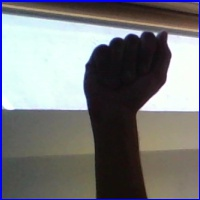

In [ ]:

import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content/drive/MyDrive/data_asl'
%cd /content/drive/MyDrive/data_asl
!ls
!kaggle datasets download -d grassknoted/asl-alphabet
!mkdir asl_recognition
!mv asl-alphabet.zip asl_recognition
%cd asl_recognition/
!unzip asl-alphabet.zip
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/drive/MyDrive/data_asl/asl_recognition/asl_alphabet_test/asl_alphabet_test/A_test.jpg')
cv2_imshow(img)

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
train_folder = '/content/drive/MyDrive/data_asl/asl_recognition/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)


In [ ]:
data_df.head

<bound method NDFrame.head of        label                                               path
0          A  /content/drive/MyDrive/data_asl/asl_recognitio...
1          A  /content/drive/MyDrive/data_asl/asl_recognitio...
2          A  /content/drive/MyDrive/data_asl/asl_recognitio...
3          A  /content/drive/MyDrive/data_asl/asl_recognitio...
4          A  /content/drive/MyDrive/data_asl/asl_recognitio...
...      ...                                                ...
86995  space  /content/drive/MyDrive/data_asl/asl_recognitio...
86996  space  /content/drive/MyDrive/data_asl/asl_recognitio...
86997  space  /content/drive/MyDrive/data_asl/asl_recognitio...
86998  space  /content/drive/MyDrive/data_asl/asl_recognitio...
86999  space  /content/drive/MyDrive/data_asl/asl_recognitio...

[87000 rows x 2 columns]>

In [ ]:
data_df['label'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype=object)

Repartition des donndonnées

In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

Redimensionnement


In [ ]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False   
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# Model


In [ ]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 29)                14877     
                                                                 
Total params: 27,774,493
Trainable params: 4,209,693
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [ ]:
classes = 29
epochs = 2
learning_rate = 0.0001

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Epoch 1/2
490/490 [==============================] - 1387s 3s/step - loss: 2.2415 - accuracy: 0.3740 - val_loss: 1.1961 - val_accuracy: 0.6757
Epoch 2/2
490/490 [==============================] - 1348s 3s/step - loss: 1.5565 - accuracy: 0.5389 - val_loss: 0.9229 - val_accuracy: 0.7315


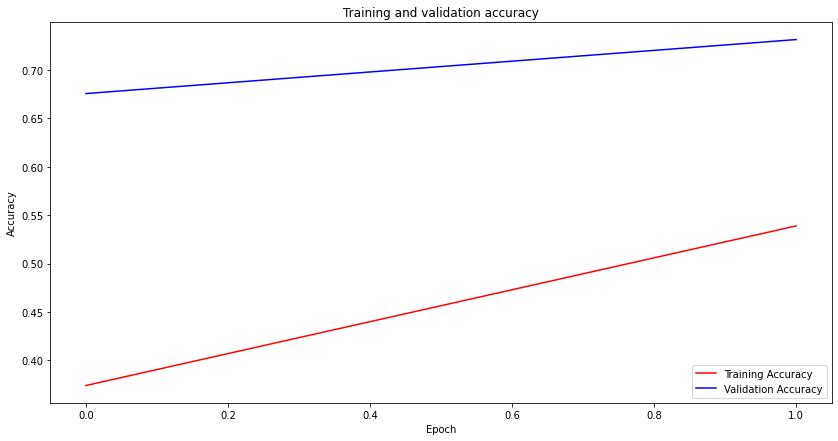

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

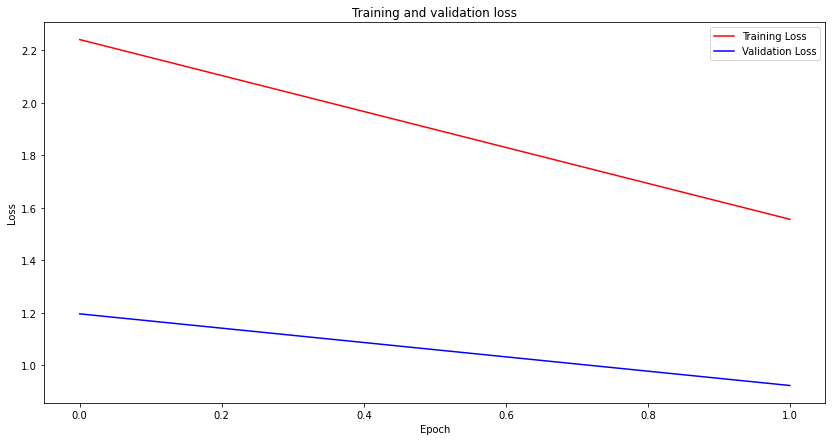

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 134s 2s/step
              precision    recall  f1-score   support

           A       0.78      0.73      0.76       300
           B       0.87      0.82      0.85       300
           C       0.97      0.74      0.84       300
           D       0.92      0.86      0.89       300
           E       0.80      0.56      0.65       300
           F       0.98      0.80      0.88       300
           G       0.89      0.74      0.81       300
           H       0.87      0.88      0.87       300
           I       0.76      0.60      0.67       300
           J       0.81      0.90      0.85       300
           K       0.68      0.67      0.68       300
           L       0.84      0.81      0.82       300
           M       0.57      0.77      0.66       300
           N       0.77      0.60      0.67       300
           O       0.87      0.83      0.85       300
           P       0.80      0.82      0.81       300
           Q       0.89    

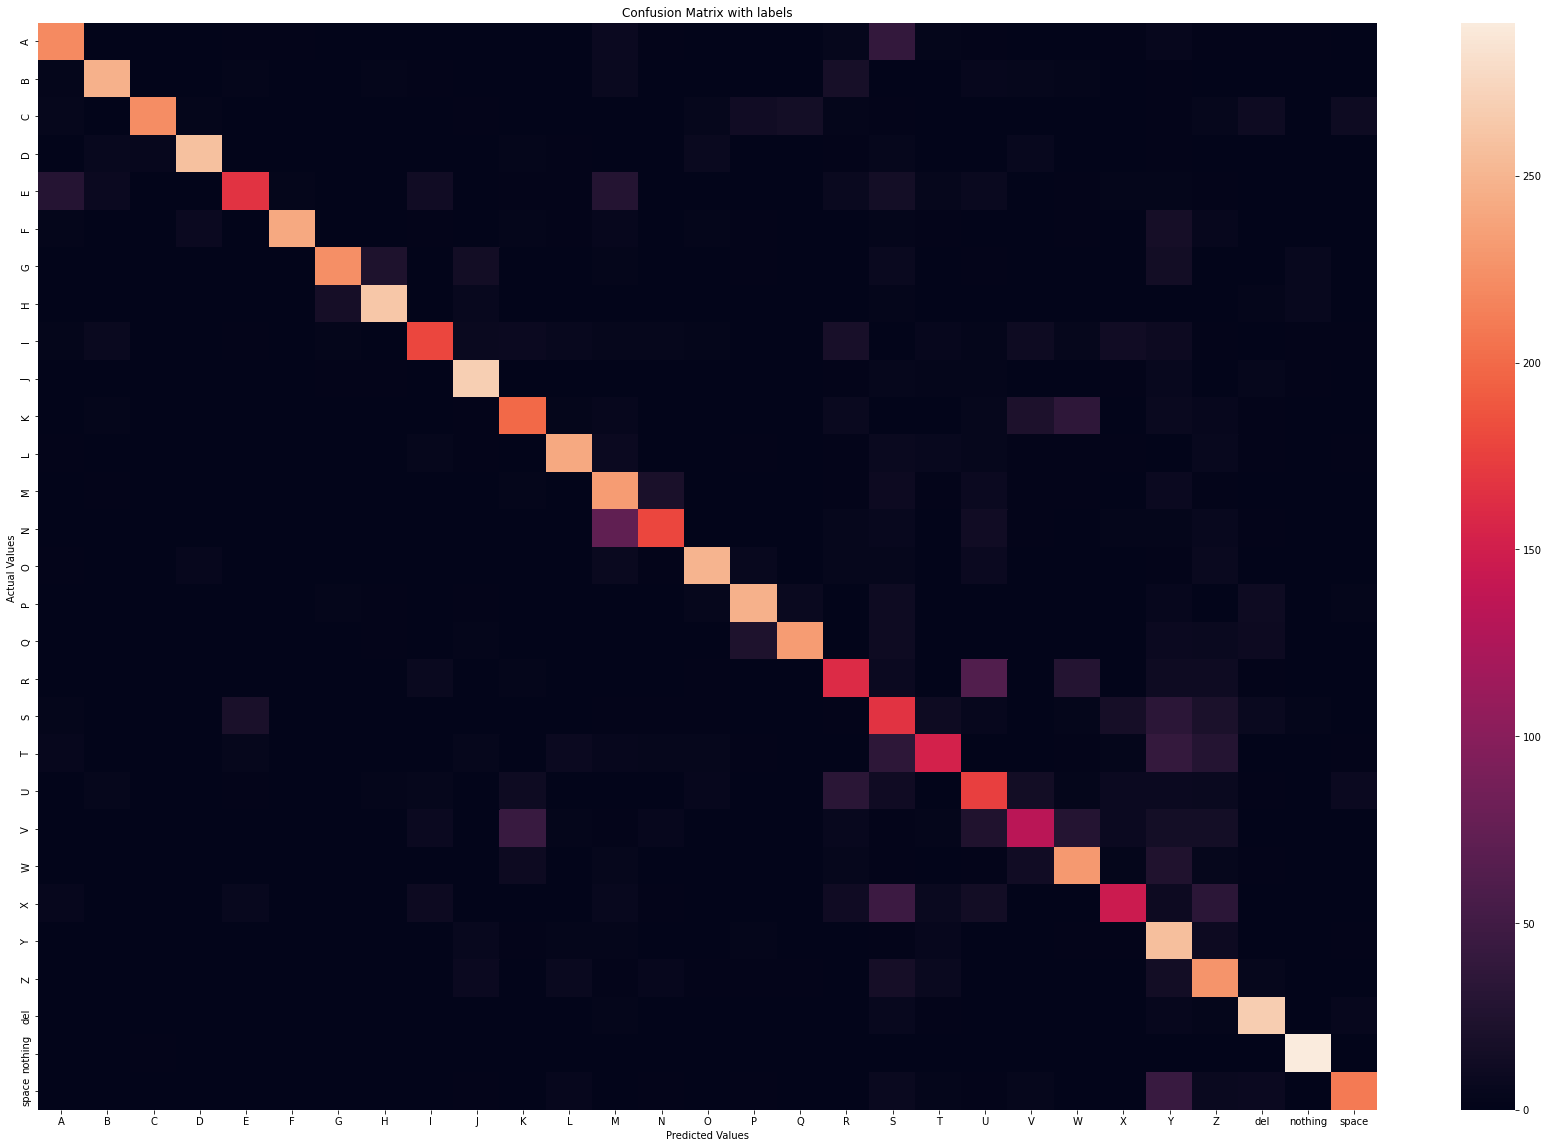

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/data_asl/ResNet50V2-asl-1.h5')

In [ ]:
from keras.models import model_from_json
json_model = model.to_json()

with open('ResNet50V2-Aug.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[220   1   0   0   2   2   0   0   1   1   0   1   8   2   0   1   0   4
   39   3   2   0   0   2   5   2   2   2   0]
 [  3 247   0   1   3   0   0   3   2   0   0   0   7   0   0   0   0  18
    1   0   5   4   3   0   2   0   0   0   1]
 [  4   0 222   3   0   0   1   1   0   2   0   0   0   0   4  13  15   3
    2   0   1   0   0   0   2   4  11   1  11]
 [  0   6   5 259   1   1   0   0   1   0   3   2   0   0   7   1   0   2
    4   0   0   6   0   0   2   0   0   0   0]
 [ 29   8   0   1 167   3   0   1  13   0   2   2  28   1   0   1   0   7
   15   4   7   0   2   3   3   2   1   0   0]
 [  3   0   0   8   1 241   0   0   2   0   3   2   5   0   3   2   0   1
    3   2   0   0   2   0  17   5   0   0   0]
 [  0   1   0   0   0   0 223  23   0  14   0   0   3   1   0   2   0   1
    7   1   2   0   0   1  14   0   1   6   0]
 [  0   0   0   0   0   0  16 263   0   6   0   0   0   0   0   0   0   0
    3   0   1   0   0   0   1   1   3   6   0]
 [  3   7   0 

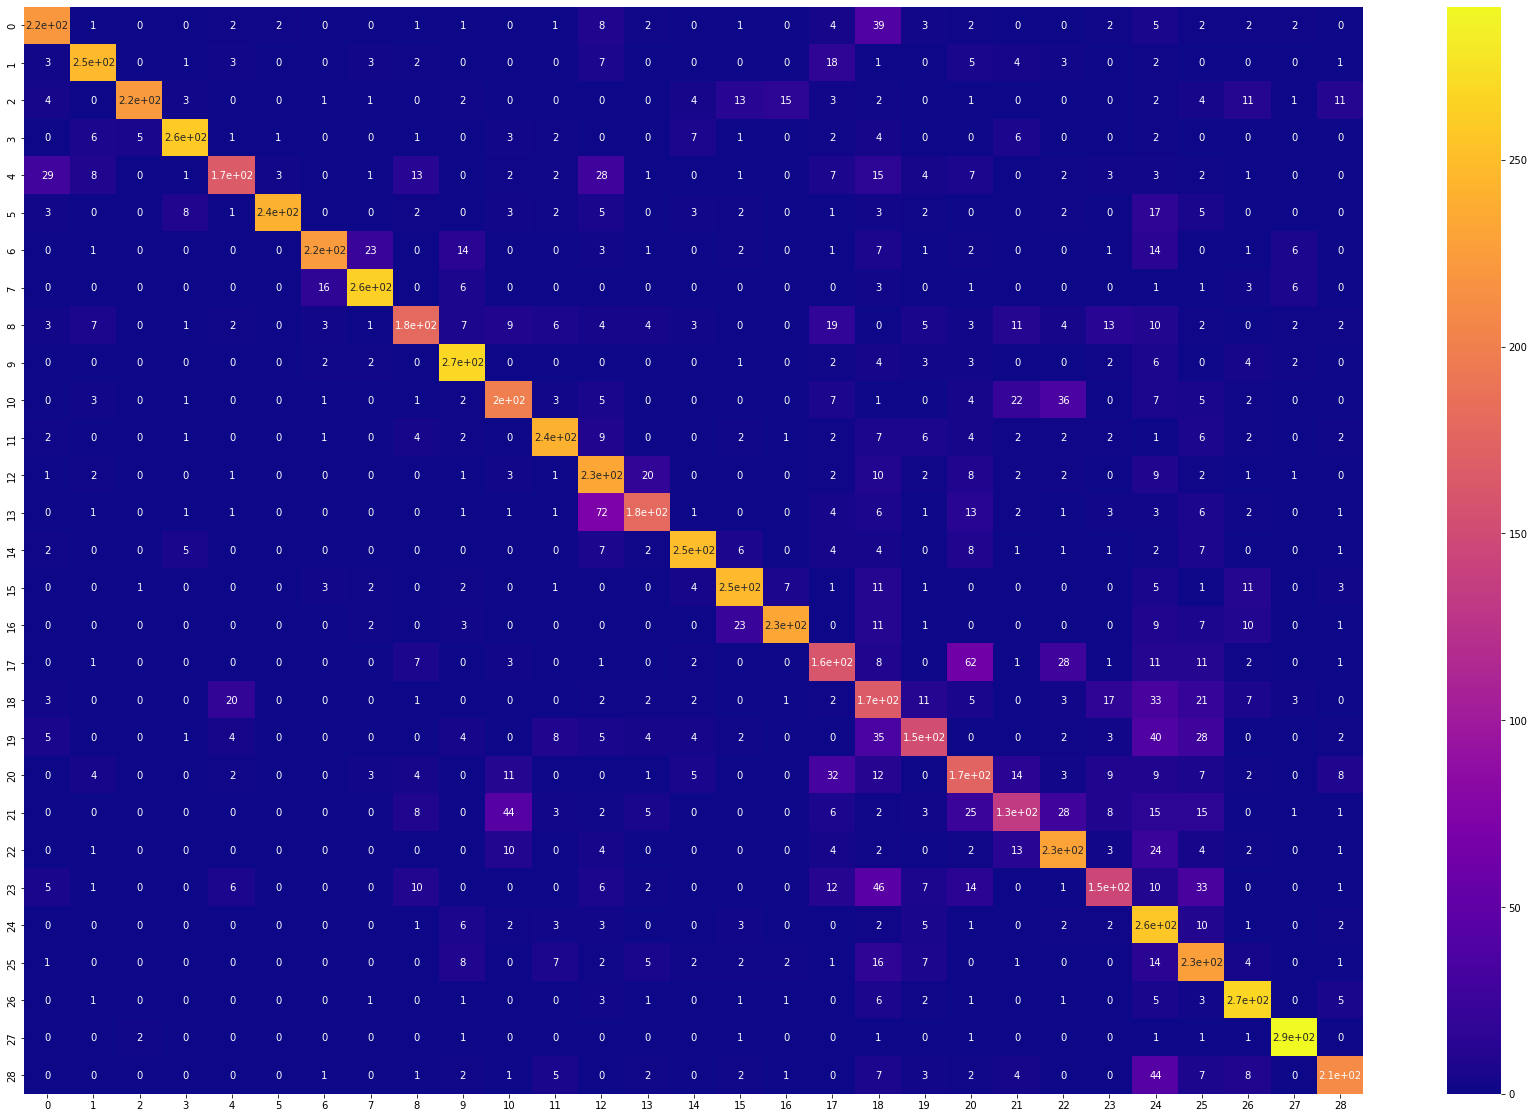

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)

# Live Model